In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad as integral
import numba
import seaborn as sns
sns.set(
    style='ticks',
    font_scale=1.5
)
import rakott.mpl
colors = rakott.mpl.color_names()

In [137]:
s = 0.1
ρ = 0.1
N = 10000

In [138]:
@numba.jit()
def step(x, s, ρ, N):
    x = ρ * x * (1 + s)/(1 + x * s) + (1 - ρ) * x
    return np.random.binomial(N, x) / N

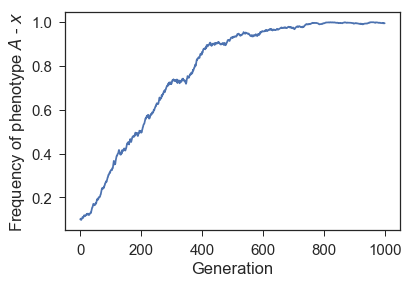

In [139]:
x = np.empty(1000, float)
x[0] = 1/10

for t in range(1, x.shape[0]):
    x[t] = step(x[t - 1], s, ρ, N)
    
plt.plot(x)
plt.xlabel('Generation')
plt.ylabel('Frequency of phenotype $A$ - $x$')

# Fixation probability

In [140]:
def u(x, s, ρ, N):
    result = np.empty_like(ρ)
    s = N*s
    idx = s*ρ > 0
    ρ = ρ[idx]
    result[~idx] = x
    result[idx] = (1 - np.exp(-2*ρ*s*x))/(1 - np.exp(-2*ρ*s))
    return result

In [141]:
@numba.jit()
def fixation(x, s, ρ, N, reps=1, x1=1-1e-6):
    N = int(N)
    x = np.full((reps), x, float)
    update = (0 < x) & (x < x1)
    t = np.full((reps), 0, int)
    while update.any():
        t[update] += 1
        x[update] = step(x[update], s, ρ, N)
        update = (0 < x) & (x < x1)
    return x != 0, t

In [142]:
def fix_prob(x, s, ρ, N, reps=1000, x1=1-1e-6):
    return fixation(1/N, s, ρ, N, reps, x1)[0].mean()

In [143]:
ρs = np.linspace(0, 1)[1:-1]
probs = [
    fix_prob(1/N, s, ρ, N, 10000)
    for ρ in ρs
]

In [144]:
us = u(1/N, s, ρs, N)

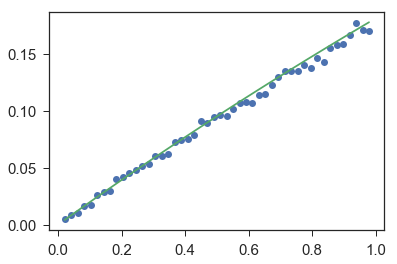

In [145]:
plt.plot(ρs, probs, 'o')
plt.plot(ρs, u(1/N, s, ρs, N) , '-')

# Fixation time

In [146]:
def u(x, s, ρ, N):
    s = N*s
    if s*ρ == 0:
        return x
    return (1 - np.exp(-2*ρ*s*x))/(1 - np.exp(-2*ρ*s))

def integrand1(z, s, ρ):
    if z == 0:
        return 0
    return (np.exp(2*s*ρ*z)-1)/(z*(1-z))

def integrand2(z, s, ρ):
    if z == 1:
        return 0
    return (1-np.exp(-2*s*ρ*(1-z)))/(z*(1-z))

def T(x, s, ρ, N):
    N = int(N)
    s = N*s
    

    if s*ρ == 0:
        return -2*x*np.log(x) -2*(1-x)*np.log(1-x)    
    
    I1 = integral(integrand1, 0, x, args=(s, ρ))[0]
    I2 = integral(integrand2, x, 1, args=(s, ρ))[0]
    
    ux = u(x, s, ρ, N)
    return N * ((1 - ux)/(s*ρ) * I1 + ux/(s*ρ) * I2)

In [147]:
def fix_time(x, s, ρ, N, reps=1000, x1=1-1e-6):
    reps = int(reps/(2*s*ρ)) if s*ρ>0 else reps
    p, t = fixation(1/N, s, ρ, N, reps, x1)
    return t[p].mean()

In [148]:
ρs = np.linspace(0, 1)[1:-1]
times = [
    fix_time(1/N, s, ρ, N, 100)
    for ρ in ρs
]

In [149]:
Ts = [
    T(1/N, s, ρ, N)
    for ρ in ρs
]

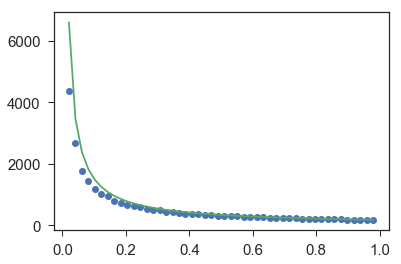

In [150]:
plt.plot(ρs, times, 'o')
plt.plot(ρs, Ts, '-')

# Combined

s=0.1, N=10000


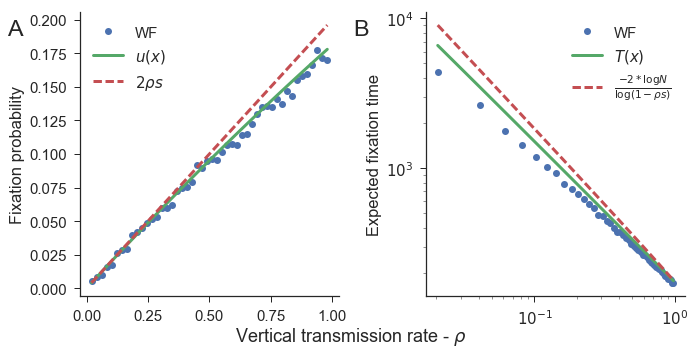

In [156]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=False, sharey=False)
marker = 'o'
lw = 3

ax = axes[0]
ax.plot(ρs, probs, marker, label='WF')
ax.plot(ρs, us , '-', lw=lw, label='$u(x)$')
ax.plot(ρs, 2*s*ρs, '--', lw=lw, label=r'$2 \rho s$')
ax.set(
    ylabel='Fixation probability',
#     xlabel=r'Vertical transmission rate - $\rho$',
#         yscale='log',
#     xscale='log'
)
ax.legend(loc='upper left')

ax = axes[1]
ax.plot(ρs, times, marker, label='WF')
ax.plot(ρs, Ts, '-', lw=lw, label='$T(x)$')
ax.plot(ρs, -2*np.log(N)/np.log(1-ρs*s), ls='--', lw=lw, label=r'$\frac{-2*\log{N}}{\log{(1-\rho s)}}$')

ax.set(
#     xlabel=r'Vertical transmission rate - $\rho$',
    ylabel='Expected fixation time',
    yscale='log',
    xscale='log'
)
ax.legend(loc='upper right')

rakott.mpl.fig_xlabel(fig, r'Vertical transmission rate - $\rho$')
rakott.mpl.fig_panel_labels(axes, xcoord=-0.28)

fig.tight_layout()
sns.despine()
fig.savefig('../figures/fixation_prob_time.pdf')
print("s={}, N={}".format(s, N))